In [1]:
# import the libraries and connect to the database
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# restart a new connection
conn = mysql.connector.connect(user='root', password='sql',
                              host='localhost')
cur = conn.cursor(buffered=True)
cur.execute("USE `sales`")

In [17]:
# examine the average monthly transactions
sql = "SELECT date, sum(transactions) as transactions FROM transactions GROUP BY date;"
cur.execute(sql)
query = cur.fetchall()
transactions = pd.DataFrame(query, columns=['date', "transactions"])
transactions.date = pd.to_datetime(transactions.date)
transactions.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573


In [19]:
from datetime import date, timedelta

start_date = pd.to_datetime("2013-01-01")
end_date = pd.to_datetime("2017-08-15") - timedelta(days=1) #Excluding last

#List of all dates
all_date = pd.date_range(start_date, end_date, freq='d')

#Left join your main data on dates data
all_date_df = pd.DataFrame({'date':all_date})
transactions2 = pd.merge(all_date_df, transactions, on='date', how="left")
transactions2.fillna(0, inplace=True)
transactions2.head()

,date,transactions
0,2013-01-01,770
1,2013-01-02,93215
2,2013-01-03,78504
3,2013-01-04,78494
4,2013-01-05,93573


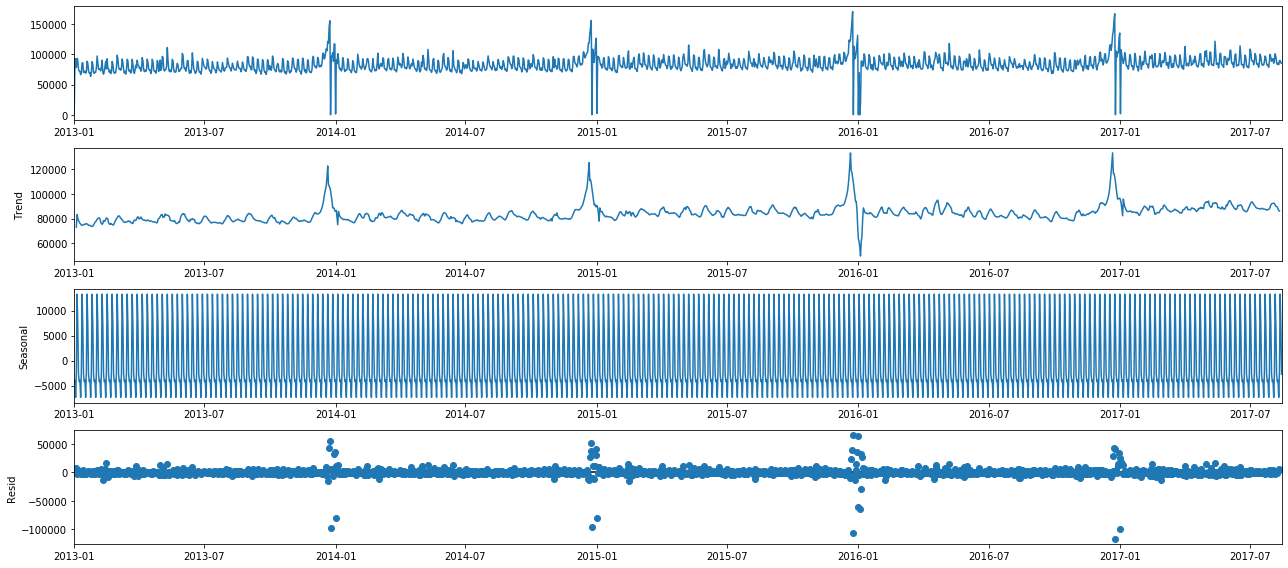

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
transactions2.transactions = transactions2.transactions.astype('int64')
extract = transactions2.set_index('date')
decomposition = seasonal_decompose(extract, model='additive')
fig = decomposition.plot()
plt.show()

1. Stationarity: Using Dickey Fuller Test of Stationarity (p-value = 0.05)

(https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/#:~:text=%C2%A0-,Dickey%20Fuller%20Test%20of%20Stationarity,-What%20you%20just)

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.
- **Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- **Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [29]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(transactions['transactions'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.956375
p-value: 0.000000


We reject the null hypothesis, our data is stationary.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version


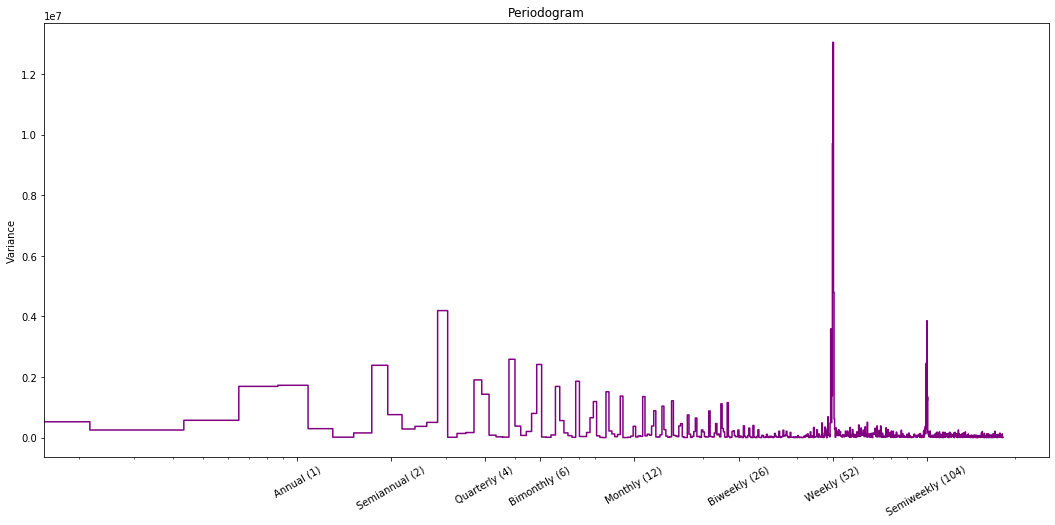

In [46]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    real_spectrum = []
    for i in spectrum:
        real_spectrum.append(i.real)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, real_spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(transactions['transactions']);